- In this notebook we will repeat all the preprocessing steps for ONLY the labelled data. Later on we will use the data to build our classification model.

### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sb
from collections import Counter
import tqdm
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import unicodedata
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from wordcloud import WordCloud, STOPWORDS
import gensim
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import precision_recall_fscore_support
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.metrics import f1_score, accuracy_score , recall_score , precision_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

C:\Users\tooba\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


To do:
- TFIDF for both fake and real news
-

### Data Cleaning

In [3]:
dawn = pd.read_csv('dawn-annotated.csv')
dawn.head()

,News ID,URL,Headline,Date,Content,Author,Publisher,News Category,Keywords,Label
0,0,https://www.dawn.com/news/1458127/mbbs-student...,MBBS student found dead in hostel room at Jams...,1/17/2019,A third-year MBBS student was found shot dead ...,Mohammad Hussain Khan,Dawn,Mental health,"Jamshoro, youth, suicide, mental health",1.0
1,1,https://www.dawn.com/news/1458129/govt-decides...,"Govt decides to remove names of Bilawal, Murad...",1/17/2019,The federal cabinet has decided to remove the ...,Sanaullah Khan | Javed Hussain,Dawn,Politics,"Islamabad, Sindh, PPP, ECL",1.0
2,2,https://www.dawn.com/news/1458125/afghan-presi...,Afghan president thanks PM Khan for Pakistan's...,1/17/2019,Afghan President Ashraf Ghani on Thursday tele...,Sanaullah Khan,Dawn,Foreign Affairs,"Afghanistan, foreign affairs, Imran Khan, Ashr...",1.0
3,3,https://www.dawn.com/news/1458123/mehwish-haya...,Mehwish Hayat acts out her musical dreams in n...,1/17/2019,Director and script writer Wajahat Rauf unveil...,None,Dawn,Entertainment,"Mehwish Hayat, Enaaya, Azfar Rehman, Wajahat Rauf",-1.0
4,4,https://www.dawn.com/news/1458118/complete-tex...,Complete text of address by Justice Asif Saeed...,1/17/2019,Complete address by Justice Asif Saeed Khosa o...,Dawn.com,Dawn,Judiciary,"Islamabad, Asif Khosa, Supreme Court, Saqib Nisar",1.0


In [4]:
# drop rows where no label given
dawn = dawn.dropna()

In [5]:
# Convert dates to datetime object
dawn['Date'] =  pd.to_datetime(dawn['Date'])

In [6]:
# Replacing None and dawn.com with dawn since no author.
dawn['Author'] = dawn['Author'].replace(to_replace=r'None', value='dawn', regex=True)
dawn['Author'] = dawn['Author'].replace(to_replace=r'Dawn.com', value='dawn', regex=True)

We have the following 5 categories with no author names so we will replace them with the name of the newspaper so that it is later easier to identify a source for these articles.
  -  The Newspaper's Staff Reporter
  - A Correspondent
  - The Newspaper's Correspondent
  - The Newspaper's Staff Correspondent
  - Editorial

In [7]:
print(dawn['Author'].unique())
print('Number of Categories',len(dawn['Author'].unique()))

['Mohammad Hussain Khan' 'Sanaullah Khan | Javed Hussain' 'Sanaullah Khan'
 'dawn' 'dawn | Haseeb Bhatti' 'Rimmel Mohydin' 'Jamil Nagri'
 'Bureau Report' 'Kashif Abbasi' 'Ikram Junaidi'
 "The Newspaper's Staff Reporter" 'Naeem Sahoutara' 'Habib Khan Ghori'
 'Hasan Mansoor' 'Behram Baloch' 'Mohammad Asghar' 'Imran Ayub'
 'Syed Ali Shah' 'Haseeb Bhatti' 'Ali Akbar | AP' 'Rana Bilal'
 'Sara Malkani' 'Editorial' 'Munawer Azeem' 'A Correspondent'
 "The Newspaper's Correspondent" 'Zulfiqar Ali' 'Intikhab Hanif'
 'Tahir Siddiqui' 'Ishaq Tanoli' 'Faiza Ilyas' 'Tariq Naqash' 'Imtiaz Ali'
 'Tahir Naseer' 'Wajiha Khanain' 'Abdul Ghaffar' 'AP'
 'Amir Wasim | Javed Hussain | Nadir Guramani' 'Jawaid Bokhari'
 'Dr Niaz Murtaza' 'Amjad Iqbal' 'Hamid Asghar' 'APP'
 "The Newspaper's Staff Correspondent" 'Zulqernain Tahir'
 'Ghulam Hussain Khawaja' 'Dawn Report' 'Syed Irfan Raza'
 'Monitoring Desk' 'Malik Asad' 'Syed Ali Shah | APP' 'dawn | Amir Wasim'
 'Javed Hussain' 'Shakeel Qarar' 'Umair Javed' 'Nadi

In [8]:
dawn['Author'] = dawn['Author'].replace(to_replace=r'The Newspaper\'s Staff Reporter', value='dawn', regex=True)
dawn['Author'] = dawn['Author'].replace(to_replace=r'A Correspondent', value='dawn', regex=True)
dawn['Author'] = dawn['Author'].replace(to_replace=r'The Newspaper\'s Correspondent', value='dawn', regex=True)
dawn['Author'] = dawn['Author'].replace(to_replace=r'Editorial', value='dawn', regex=True)
dawn['Author'] = dawn['Author'].replace(to_replace=r'The Newspaper\'s Staff Correspondent', value='dawn', regex=True)

In [9]:
print('Number of Categories are:',len(dawn['Author'].unique()))

Number of Categories are: 65


In [10]:
data = dawn.copy()
data.head()

,News ID,URL,Headline,Date,Content,Author,Publisher,News Category,Keywords,Label
0,0,https://www.dawn.com/news/1458127/mbbs-student...,MBBS student found dead in hostel room at Jams...,2019-01-17,A third-year MBBS student was found shot dead ...,Mohammad Hussain Khan,Dawn,Mental health,"Jamshoro, youth, suicide, mental health",1.0
1,1,https://www.dawn.com/news/1458129/govt-decides...,"Govt decides to remove names of Bilawal, Murad...",2019-01-17,The federal cabinet has decided to remove the ...,Sanaullah Khan | Javed Hussain,Dawn,Politics,"Islamabad, Sindh, PPP, ECL",1.0
2,2,https://www.dawn.com/news/1458125/afghan-presi...,Afghan president thanks PM Khan for Pakistan's...,2019-01-17,Afghan President Ashraf Ghani on Thursday tele...,Sanaullah Khan,Dawn,Foreign Affairs,"Afghanistan, foreign affairs, Imran Khan, Ashr...",1.0
3,3,https://www.dawn.com/news/1458123/mehwish-haya...,Mehwish Hayat acts out her musical dreams in n...,2019-01-17,Director and script writer Wajahat Rauf unveil...,dawn,Dawn,Entertainment,"Mehwish Hayat, Enaaya, Azfar Rehman, Wajahat Rauf",-1.0
4,4,https://www.dawn.com/news/1458118/complete-tex...,Complete text of address by Justice Asif Saeed...,2019-01-17,Complete address by Justice Asif Saeed Khosa o...,dawn,Dawn,Judiciary,"Islamabad, Asif Khosa, Supreme Court, Saqib Nisar",1.0


In [11]:
# Keeping only the date part of the datetime object for consistency.
data['Date'] = data['Date'].dt.date

In [12]:
# Converting label from floats to int
data['Label'] = data['Label'].astype(int)

In [13]:
# Saving cleaned data
data.to_csv('dawn-annotated-cleaned.csv',index=False)

In [14]:
data = pd.read_csv('dawn-annotated-cleaned.csv')
data.head()

,News ID,URL,Headline,Date,Content,Author,Publisher,News Category,Keywords,Label
0,0,https://www.dawn.com/news/1458127/mbbs-student...,MBBS student found dead in hostel room at Jams...,2019-01-17,A third-year MBBS student was found shot dead ...,Mohammad Hussain Khan,Dawn,Mental health,"Jamshoro, youth, suicide, mental health",1
1,1,https://www.dawn.com/news/1458129/govt-decides...,"Govt decides to remove names of Bilawal, Murad...",2019-01-17,The federal cabinet has decided to remove the ...,Sanaullah Khan | Javed Hussain,Dawn,Politics,"Islamabad, Sindh, PPP, ECL",1
2,2,https://www.dawn.com/news/1458125/afghan-presi...,Afghan president thanks PM Khan for Pakistan's...,2019-01-17,Afghan President Ashraf Ghani on Thursday tele...,Sanaullah Khan,Dawn,Foreign Affairs,"Afghanistan, foreign affairs, Imran Khan, Ashr...",1
3,3,https://www.dawn.com/news/1458123/mehwish-haya...,Mehwish Hayat acts out her musical dreams in n...,2019-01-17,Director and script writer Wajahat Rauf unveil...,dawn,Dawn,Entertainment,"Mehwish Hayat, Enaaya, Azfar Rehman, Wajahat Rauf",-1
4,4,https://www.dawn.com/news/1458118/complete-tex...,Complete text of address by Justice Asif Saeed...,2019-01-17,Complete address by Justice Asif Saeed Khosa o...,dawn,Dawn,Judiciary,"Islamabad, Asif Khosa, Supreme Court, Saqib Nisar",1


In [15]:
# Number of articles for each author
Counter(data.Author)

Counter({'Mohammad Hussain Khan': 2,
         'Sanaullah Khan | Javed Hussain': 1,
         'Sanaullah Khan': 3,
         'dawn': 67,
         'dawn | Haseeb Bhatti': 1,
         'Rimmel Mohydin': 1,
         'Jamil Nagri': 1,
         'Bureau Report': 4,
         'Kashif Abbasi': 2,
         'Ikram Junaidi': 3,
         'Naeem Sahoutara': 3,
         'Habib Khan Ghori': 1,
         'Hasan Mansoor': 3,
         'Behram Baloch': 1,
         'Mohammad Asghar': 2,
         'Imran Ayub': 2,
         'Syed Ali Shah': 1,
         'Haseeb Bhatti': 9,
         'Ali Akbar | AP': 1,
         'Rana Bilal': 4,
         'Sara Malkani': 1,
         'Munawer Azeem': 1,
         'Zulfiqar Ali': 2,
         'Intikhab Hanif': 1,
         'Tahir Siddiqui': 2,
         'Ishaq Tanoli': 1,
         'Faiza Ilyas': 1,
         'Tariq Naqash': 1,
         'Imtiaz Ali': 2,
         'Tahir Naseer': 1,
         'Wajiha Khanain': 1,
         'Abdul Ghaffar': 1,
         'AP': 1,
         'Amir Wasim | Javed Hussai

In [16]:
print('Total size of dataset is :',data.shape)

Total size of dataset is : (162, 10)


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 10 columns):
News ID          162 non-null int64
URL              162 non-null object
Headline         162 non-null object
Date             162 non-null object
Content          162 non-null object
Author           162 non-null object
Publisher        162 non-null object
News Category    162 non-null object
Keywords         162 non-null object
Label            162 non-null int64
dtypes: int64(2), object(8)
memory usage: 12.7+ KB


In [18]:
print('Range of the published articles is',data.Date.min(),'-',data.Date.max())

Range of the published articles is 2019-01-13 - 2019-01-17


 - Find importance of words using headlines and content seperately

### Preprocessing

In [19]:
def remove_non_ascii(words):
    words = [unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore') for word in words]
    return words
# The first pre-processing step which we will do is transform our tweets into lower case.
# This avoids having multiple copies of the same words
def to_lowercase(words):
    words = [word.lower() for word in words]
    return words
# Removing punctuation to reduce the amount of the training data
def remove_punctuation(words):
    words = [re.sub(r'[^\w\s]', '', word) for word in words if re.sub(r'[^\w\s]', '', word) not in '']    
    return words
# Removing numbers from data since they aren't useful in this context.
def replace_numbers(words):
    words = [re.sub(r'[^\w\s]', '', word) for word in words]
    return words
def remove_stopwords(words):
    words = [word for word in words if word not in stopwords.words('english')]
    return words

In [20]:
def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    words = remove_stopwords(words)
    return words

In [21]:
data['tokenized_Content'] = data['Content'].apply(word_tokenize)
data['tokenized_Headline'] = data['Headline'].apply(word_tokenize)
data['tokenized_Content'] = data['tokenized_Content'].apply(normalize)
data['tokenized_Headline'] = data['tokenized_Headline'].apply(normalize)

In [22]:
# data['tokenized_Keywords'] = data['Keywords'].apply(word_tokenize)
# data['tokenized_Keywords'] = data['tokenized_Keywords'].apply(normalize)

In [23]:
data['tokenized_Headline'][5]

['profile', 'pakistan', 'next', 'chief', 'justice', 'asif', 'saeed', 'khosa']

In [24]:
data.head()

,News ID,URL,Headline,Date,Content,Author,Publisher,News Category,Keywords,Label,tokenized_Content,tokenized_Headline
0,0,https://www.dawn.com/news/1458127/mbbs-student...,MBBS student found dead in hostel room at Jams...,2019-01-17,A third-year MBBS student was found shot dead ...,Mohammad Hussain Khan,Dawn,Mental health,"Jamshoro, youth, suicide, mental health",1,"[thirdyear, mbbs, student, found, shot, dead, ...","[mbbs, student, found, dead, hostel, room, jam..."
1,1,https://www.dawn.com/news/1458129/govt-decides...,"Govt decides to remove names of Bilawal, Murad...",2019-01-17,The federal cabinet has decided to remove the ...,Sanaullah Khan | Javed Hussain,Dawn,Politics,"Islamabad, Sindh, PPP, ECL",1,"[federal, cabinet, decided, remove, names, ppp...","[govt, decides, remove, names, bilawal, murad,..."
2,2,https://www.dawn.com/news/1458125/afghan-presi...,Afghan president thanks PM Khan for Pakistan's...,2019-01-17,Afghan President Ashraf Ghani on Thursday tele...,Sanaullah Khan,Dawn,Foreign Affairs,"Afghanistan, foreign affairs, Imran Khan, Ashr...",1,"[afghan, president, ashraf, ghani, thursday, t...","[afghan, president, thanks, pm, khan, pakistan..."
3,3,https://www.dawn.com/news/1458123/mehwish-haya...,Mehwish Hayat acts out her musical dreams in n...,2019-01-17,Director and script writer Wajahat Rauf unveil...,dawn,Dawn,Entertainment,"Mehwish Hayat, Enaaya, Azfar Rehman, Wajahat Rauf",-1,"[director, script, writer, wajahat, rauf, unve...","[mehwish, hayat, acts, musical, dreams, new, w..."
4,4,https://www.dawn.com/news/1458118/complete-tex...,Complete text of address by Justice Asif Saeed...,2019-01-17,Complete address by Justice Asif Saeed Khosa o...,dawn,Dawn,Judiciary,"Islamabad, Asif Khosa, Supreme Court, Saqib Nisar",1,"[complete, address, justice, asif, saeed, khos...","[complete, text, address, justice, asif, saeed..."


In [25]:
# Saving the clean data to a csv file
data.to_csv("preprocessed.csv",index=False)

In [2]:
data = pd.read_csv('preprocessed.csv')
data.head()

,News ID,URL,Headline,Date,Content,Author,Publisher,News Category,Keywords,Label,tokenized_Content,tokenized_Headline
0,0,https://www.dawn.com/news/1458127/mbbs-student...,MBBS student found dead in hostel room at Jams...,2019-01-17,A third-year MBBS student was found shot dead ...,Mohammad Hussain Khan,Dawn,Mental health,"Jamshoro, youth, suicide, mental health",1,"['thirdyear', 'mbbs', 'student', 'found', 'sho...","['mbbs', 'student', 'found', 'dead', 'hostel',..."
1,1,https://www.dawn.com/news/1458129/govt-decides...,"Govt decides to remove names of Bilawal, Murad...",2019-01-17,The federal cabinet has decided to remove the ...,Sanaullah Khan | Javed Hussain,Dawn,Politics,"Islamabad, Sindh, PPP, ECL",1,"['federal', 'cabinet', 'decided', 'remove', 'n...","['govt', 'decides', 'remove', 'names', 'bilawa..."
2,2,https://www.dawn.com/news/1458125/afghan-presi...,Afghan president thanks PM Khan for Pakistan's...,2019-01-17,Afghan President Ashraf Ghani on Thursday tele...,Sanaullah Khan,Dawn,Foreign Affairs,"Afghanistan, foreign affairs, Imran Khan, Ashr...",1,"['afghan', 'president', 'ashraf', 'ghani', 'th...","['afghan', 'president', 'thanks', 'pm', 'khan'..."
3,3,https://www.dawn.com/news/1458123/mehwish-haya...,Mehwish Hayat acts out her musical dreams in n...,2019-01-17,Director and script writer Wajahat Rauf unveil...,dawn,Dawn,Entertainment,"Mehwish Hayat, Enaaya, Azfar Rehman, Wajahat Rauf",-1,"['director', 'script', 'writer', 'wajahat', 'r...","['mehwish', 'hayat', 'acts', 'musical', 'dream..."
4,4,https://www.dawn.com/news/1458118/complete-tex...,Complete text of address by Justice Asif Saeed...,2019-01-17,Complete address by Justice Asif Saeed Khosa o...,dawn,Dawn,Judiciary,"Islamabad, Asif Khosa, Supreme Court, Saqib Nisar",1,"['complete', 'address', 'justice', 'asif', 'sa...","['complete', 'text', 'address', 'justice', 'as..."


TF: How frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (the total number of terms in the document) as a way of normalization: 

TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).

IDF: Measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following: 

IDF(t) = log_e(Total number of documents / Number of documents with term t in it).

- TFIDF = TF x TDF
- Does not consider word ordering and context. 
- It is possible for two articles that are similar in their word counts to be totally different in their meaning.

In [3]:
tdf = TfidfVectorizer(stop_words='english',ngram_range=(1,2))
vectorizer = tdf.fit(data.tokenized_Content)
transformed_text = vectorizer.transform(data.tokenized_Content)

In [4]:
transformed_text

<162x46230 sparse matrix of type '<class 'numpy.float64'>'
	with 71166 stored elements in Compressed Sparse Row format>

In [5]:
# features created by TFIDF
feature_names = tdf.get_feature_names()
len(feature_names)

46230

In [6]:
def tfidf_scores(feature_names):
    "Returns dictionary with term names and total tfidf scores for all terms in corpus"
# We take transpose so that for each word we can see the tfidf score acorss each row.
#For total tfidf of one word we add all the values of that word across all the documents.
#array is of size 398(number of rows in data)
# For each term we are adding its 398 matrix
    term_dict = {}
    for i,term in enumerate(feature_names):
        term_name = feature_names[i]
        term_dict[term_name] = np.sum(transformed_text.T[i].toarray())   
    return term_dict

In [7]:
term_dict = tfidf_scores(feature_names)

In [8]:
print ('Number of terms/keys are: ',len(term_dict.keys()))

Number of terms/keys are:  46230


In [9]:
def sorted_tfidf_scores(term_dict):
# [::-1] Gives the index in descending order.  
    sort_index = np.argsort(list(term_dict.values()))[::-1]
    terms = np.array(list(term_dict.keys()))
    scores = np.array(list(term_dict.values()))
    terms = terms[sort_index]
    scores = scores[sort_index]
    return terms, scores

In [10]:
terms, scores = sorted_tfidf_scores(term_dict)

In [11]:
"Returns plot accordng to importance of top N terms/words"
def plot(scores,terms, words = 30):
    fig = plt.figure(figsize = (20, 20))
    override = {'fontsize': 'large'}
    sb.barplot(x = scores[:words], y = terms[:words]);
    plt.title("Importance of Top {0} Terms".format(words),fontsize = 40)
    plt.xlabel("TFIDF Score",fontsize = 30)

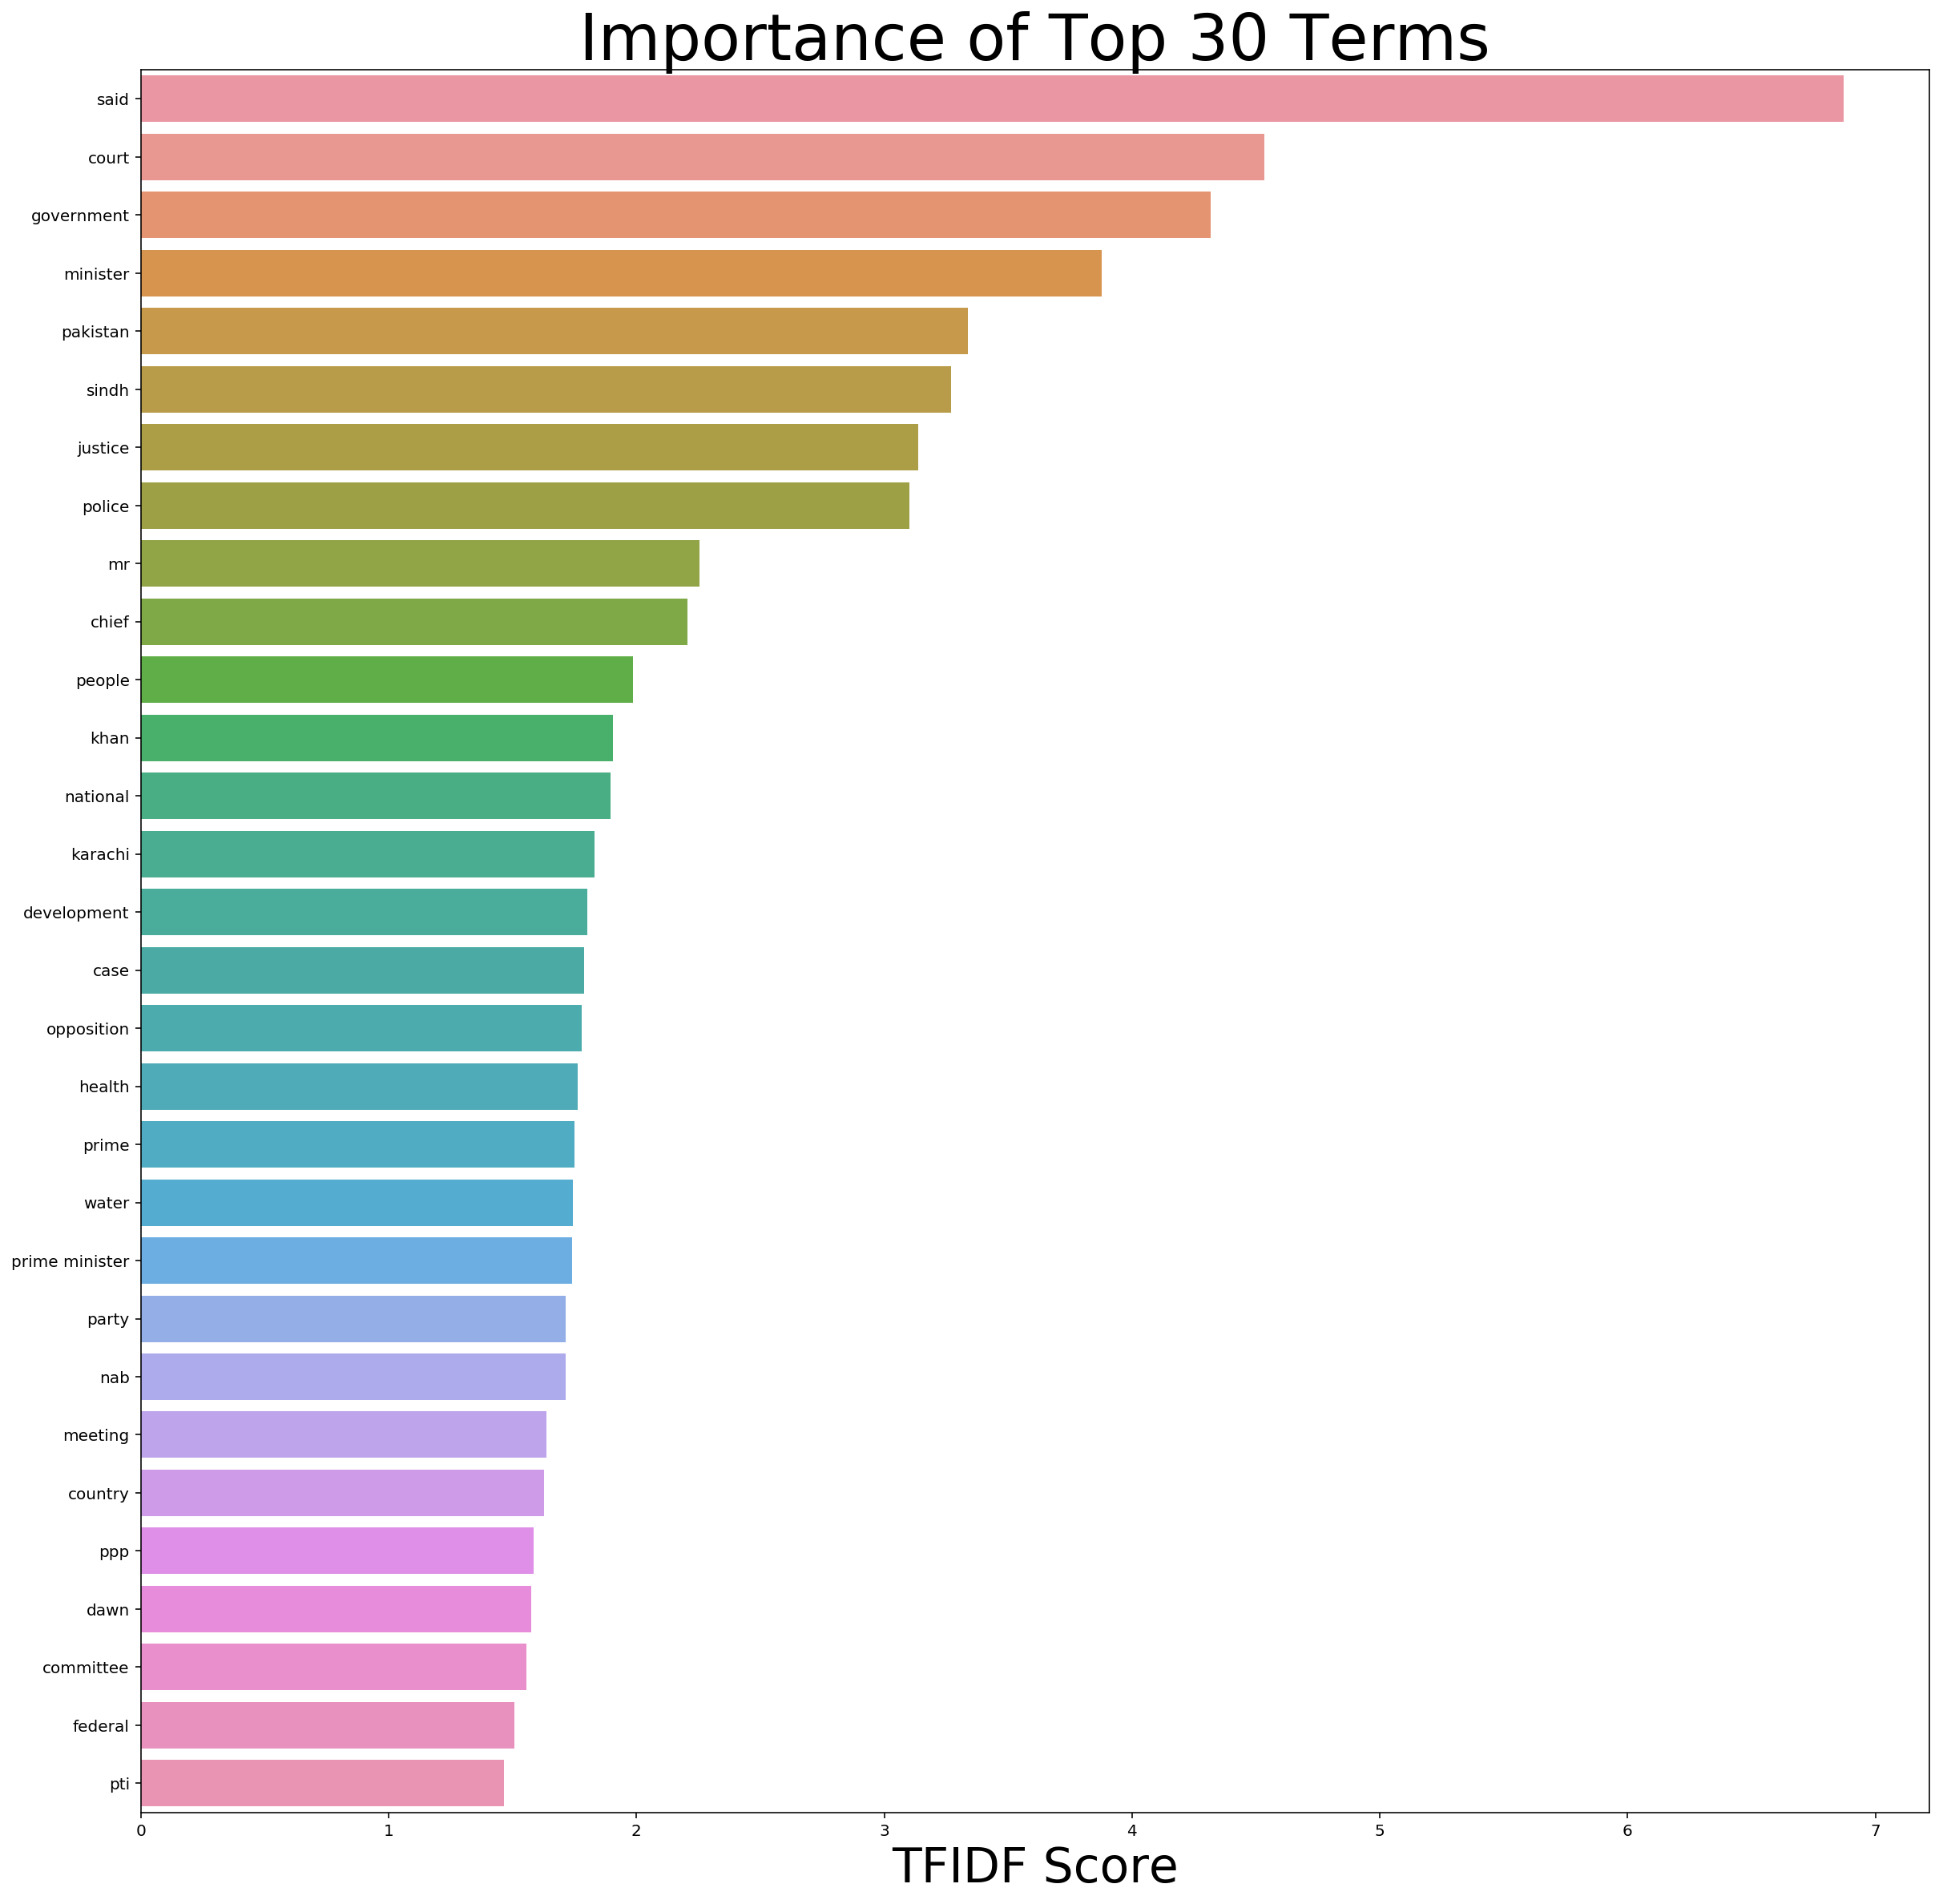

In [12]:
plot(scores, terms, words = 30)

We can see from the above plot that the most common news in the scope of our data is related to goverment,justice, police which comes under the category of politics.

In [13]:
data['Length'] = [len(headline) for headline in data['Headline']]
data.head()

,News ID,URL,Headline,Date,Content,Author,Publisher,News Category,Keywords,Label,tokenized_Content,tokenized_Headline,Length
0,0,https://www.dawn.com/news/1458127/mbbs-student...,MBBS student found dead in hostel room at Jams...,2019-01-17,A third-year MBBS student was found shot dead ...,Mohammad Hussain Khan,Dawn,Mental health,"Jamshoro, youth, suicide, mental health",1,"['thirdyear', 'mbbs', 'student', 'found', 'sho...","['mbbs', 'student', 'found', 'dead', 'hostel',...",73
1,1,https://www.dawn.com/news/1458129/govt-decides...,"Govt decides to remove names of Bilawal, Murad...",2019-01-17,The federal cabinet has decided to remove the ...,Sanaullah Khan | Javed Hussain,Dawn,Politics,"Islamabad, Sindh, PPP, ECL",1,"['federal', 'cabinet', 'decided', 'remove', 'n...","['govt', 'decides', 'remove', 'names', 'bilawa...",59
2,2,https://www.dawn.com/news/1458125/afghan-presi...,Afghan president thanks PM Khan for Pakistan's...,2019-01-17,Afghan President Ashraf Ghani on Thursday tele...,Sanaullah Khan,Dawn,Foreign Affairs,"Afghanistan, foreign affairs, Imran Khan, Ashr...",1,"['afghan', 'president', 'ashraf', 'ghani', 'th...","['afghan', 'president', 'thanks', 'pm', 'khan'...",90
3,3,https://www.dawn.com/news/1458123/mehwish-haya...,Mehwish Hayat acts out her musical dreams in n...,2019-01-17,Director and script writer Wajahat Rauf unveil...,dawn,Dawn,Entertainment,"Mehwish Hayat, Enaaya, Azfar Rehman, Wajahat Rauf",-1,"['director', 'script', 'writer', 'wajahat', 'r...","['mehwish', 'hayat', 'acts', 'musical', 'dream...",71
4,4,https://www.dawn.com/news/1458118/complete-tex...,Complete text of address by Justice Asif Saeed...,2019-01-17,Complete address by Justice Asif Saeed Khosa o...,dawn,Dawn,Judiciary,"Islamabad, Asif Khosa, Supreme Court, Saqib Nisar",1,"['complete', 'address', 'justice', 'asif', 'sa...","['complete', 'text', 'address', 'justice', 'as...",94


- From now onwards we will try to find the best model and features according to our data using exhaustive research.

### Grid Search 
- We perform grid search for all the models and features to find the best combination of model, features and hyperparameters.

#### Logistic Regression with TFIDF

In [3]:
X = data.tokenized_Content
y = data['Label']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=1234)
print('X_train',X_train.shape)
print('X_test',X_test.shape)
print('y_train',y_train.shape)
print('y_test',y_test.shape)

X_train (129,)
X_test (33,)
y_train (129,)
y_test (33,)


In [4]:
# max_df is used for removing terms that appear too frequently
# max_df = 0.50 means "ignore terms that appear in more than 50% of the documents"
# min_df is used for removing terms that appear too infrequently
# min_df = 0.01 means "ignore terms that appear in less than 1% of the documents"
parameters = {'lr__penalty': ('l1','l2'),'tfidf__ngram_range': [(1,1),(1,2),(1,3)],'tfidf__max_df': [0.65,0.75,0.85,0.90],
             'tfidf__min_df': [0.001,0.01],'tfidf__stop_words': [ENGLISH_STOP_WORDS]}

In [5]:
text_clf = Pipeline([('tfidf', TfidfVectorizer()),('lr', LogisticRegression())])

In [6]:
# These are the parameters we can put in the list for the model and features.
text_clf.get_params().keys()

dict_keys(['memory', 'steps', 'tfidf', 'lr', 'tfidf__analyzer', 'tfidf__binary', 'tfidf__decode_error', 'tfidf__dtype', 'tfidf__encoding', 'tfidf__input', 'tfidf__lowercase', 'tfidf__max_df', 'tfidf__max_features', 'tfidf__min_df', 'tfidf__ngram_range', 'tfidf__norm', 'tfidf__preprocessor', 'tfidf__smooth_idf', 'tfidf__stop_words', 'tfidf__strip_accents', 'tfidf__sublinear_tf', 'tfidf__token_pattern', 'tfidf__tokenizer', 'tfidf__use_idf', 'tfidf__vocabulary', 'lr__C', 'lr__class_weight', 'lr__dual', 'lr__fit_intercept', 'lr__intercept_scaling', 'lr__max_iter', 'lr__multi_class', 'lr__n_jobs', 'lr__penalty', 'lr__random_state', 'lr__solver', 'lr__tol', 'lr__verbose', 'lr__warm_start'])

In [7]:
gs_lr = GridSearchCV(text_clf, parameters, cv=3, iid=False, n_jobs=-1)
gs_lr = gs_lr.fit(X_train, y_train)
predicted = gs_lr.predict(X_test)

C:\Users\tooba\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\tooba\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



In [8]:
# Score only on the test set. NO CV
print ("Logistig Regression: \n")
print ( "F1 score {:.4}%".format(f1_score(y_test, predicted, average='macro')*100 ) )
print ( "Accuracy score {:.4}%\n\n".format(accuracy_score(y_test, predicted)*100) )
error = mean_squared_error(y_test, predicted)
print('MSE',error)

Logistig Regression: 



C:\Users\tooba\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



F1 score 28.74%
Accuracy score 75.76%


MSE 0.3333333333333333


In [9]:
print(metrics.classification_report(y_test, predicted,target_names=['Fake','Unverified','Real']))

C:\Users\tooba\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

C:\Users\tooba\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

C:\Users\tooba\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



              precision    recall  f1-score   support

        Fake       0.00      0.00      0.00         1
  Unverified       0.00      0.00      0.00         7
        Real       0.76      1.00      0.86        25

   micro avg       0.76      0.76      0.76        33
   macro avg       0.25      0.33      0.29        33
weighted avg       0.57      0.76      0.65        33



In [10]:
# print(gs_svm.score(X_test, y_test))
# Mean score  on CV
print('Best score of LR on CV: ',gs_lr.best_score_)
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_lr.best_params_[param_name]))

Best score of LR on CV:  0.6899895969663411
lr__penalty: 'l1'
tfidf__max_df: 0.65
tfidf__min_df: 0.001
tfidf__ngram_range: (1, 1)
tfidf__stop_words: frozenset({'other', 'un', 'whenever', 'system', 'am', 'de', 'get', 'seemed', 'two', 'amount', 'next', 'eg', 'that', 'you', 'would', 'been', 'herein', 'made', 'another', 'meanwhile', 'neither', 'thin', 'still', 'do', 'due', 'others', 'per', 'show', 'although', 'empty', 'after', 'above', 'whither', 'hereby', 'though', 'behind', 'this', 'else', 'throughout', 'mill', 'his', 'less', 'nine', 'their', 'by', 'will', 'anyway', 'also', 'often', 'rather', 'not', 'now', 'otherwise', 'see', 'whereas', 'why', 'any', 'about', 'ever', 'etc', 'front', 'please', 'through', 'whether', 'thence', 'becomes', 'five', 'hereafter', 'most', 'mostly', 'many', 'ourselves', 'put', 'something', 'towards', 'so', 'us', 'what', 'mine', 'an', 'it', 'namely', 'via', 'there', 'describe', 'had', 'whatever', 'even', 'last', 'within', 'moreover', 'such', 'they', 'off', 'keep', 

- The best accuracy score we can get using Logistic regression for the cross validated data set is 68.9%

####  SVM with TFIDF

In [11]:
X = data.tokenized_Content
y = data['Label']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=1234)
print('X_train',X_train.shape)
print('X_test',X_test.shape)
print('y_train',y_train.shape)
print('y_test',y_test.shape)

X_train (129,)
X_test (33,)
y_train (129,)
y_test (33,)


In [12]:
text_clf = Pipeline([('tfidf', TfidfVectorizer()),('svm', SGDClassifier())])

In [13]:
parameters = {'svm__penalty': ('l1','l2'),'svm__alpha': (1e-2, 1e-3),
              'svm__loss': ('hinge','squared_hinge'),'tfidf__ngram_range': [(1,1),(1,2),(1,3)],
             'tfidf__max_df': [0.65,0.75,0.85,0.90],'tfidf__min_df': [0.001,0.01],'tfidf__stop_words': [ENGLISH_STOP_WORDS]}

In [14]:
# Using cross validation
# refit = True, that takes the model with the best performance based on cross-validation and retrains it in the whole dataset
gs_svm = GridSearchCV(text_clf, parameters, cv=3, iid=False, n_jobs=-1)
gs_svm = gs_svm.fit(X_train, y_train)
predicted = gs_svm.predict(X_test)

C:\Users\tooba\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning:

max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.



In [15]:
# ONLY ON TEST SET
print ("LINEAR SVM: \n")
print ( "F1 score {:.4}%".format(f1_score(y_test, predicted, average='macro')*100 ) )
print ( "Accuracy score {:.4}%\n\n".format(accuracy_score(y_test, predicted)*100) )
error = mean_squared_error(y_test, predicted)
print('MSE',error)

LINEAR SVM: 



C:\Users\tooba\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



F1 score 34.55%
Accuracy score 72.73%


MSE 0.36363636363636365


In [16]:
print(metrics.classification_report(y_test, predicted,target_names=['Fake','Unverified','Real']))

C:\Users\tooba\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

C:\Users\tooba\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

C:\Users\tooba\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



              precision    recall  f1-score   support

        Fake       0.00      0.00      0.00         1
  Unverified       0.33      0.14      0.20         7
        Real       0.77      0.92      0.84        25

   micro avg       0.73      0.73      0.73        33
   macro avg       0.37      0.35      0.35        33
weighted avg       0.65      0.73      0.68        33



In [18]:
# Mean cross-validated score of the best_estimator
#best mean score
print('Best Accuracy score for Linear SVM for CV',gs_svm.best_score_)
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_svm.best_params_[param_name]))

Best Accuracy score for Linear SVM for CV 0.7289422463841069
svm__alpha: 0.001
svm__loss: 'squared_hinge'
svm__penalty: 'l2'
tfidf__max_df: 0.85
tfidf__min_df: 0.001
tfidf__ngram_range: (1, 2)
tfidf__stop_words: frozenset({'other', 'un', 'whenever', 'system', 'am', 'de', 'get', 'seemed', 'two', 'amount', 'next', 'eg', 'that', 'you', 'would', 'been', 'herein', 'made', 'another', 'meanwhile', 'neither', 'thin', 'still', 'do', 'due', 'others', 'per', 'show', 'although', 'empty', 'after', 'above', 'whither', 'hereby', 'though', 'behind', 'this', 'else', 'throughout', 'mill', 'his', 'less', 'nine', 'their', 'by', 'will', 'anyway', 'also', 'often', 'rather', 'not', 'now', 'otherwise', 'see', 'whereas', 'why', 'any', 'about', 'ever', 'etc', 'front', 'please', 'through', 'whether', 'thence', 'becomes', 'five', 'hereafter', 'most', 'mostly', 'many', 'ourselves', 'put', 'something', 'towards', 'so', 'us', 'what', 'mine', 'an', 'it', 'namely', 'via', 'there', 'describe', 'had', 'whatever', 'even'

- The best accuracy score we can get using Linear SVM for the cross validated data set is 72.8%

#### Comparison between Logistic Regression and Linear SVM Grid Search
- The best accuracy score LR is 68.9 while for Linear SVM it is 72.8% on the cross validation data-sets.
- The accuracy score on the test data set(20% data) is 75.76% for LR while it is 72.8% for SVM (fluctuates. Maximum value seen is around 72.5% and lowest is around 68%)
- The f1 score for SVM(34.55)(flutates around 1 unit) is much better than LR(28.7). However, since both false positives and false negatives have the same cost for our problem so we are looking only at the improvement of the accuracy score.

#### Experiment 1 : Best model for Logistic Regression with TFIDF
- Text to Features: TFIDF using the article content (Try different n grams)
- Classification Model: Logistic Regression (Different penalties)
- Check different metrics and ROC curve. Confusion matrix.


In [19]:
X = data.tokenized_Content
y = data['Label']

In [20]:
tdf = TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS,ngram_range=(1,1),max_df =0.65,min_df=0.001)
vectorizer = tdf.fit(X)
transformed_text = vectorizer.transform(X)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(transformed_text,y, test_size = 0.2, random_state=1234)
print('X_train',X_train.shape)
print('X_test',X_test.shape)
print('y_train',y_train.shape)
print('y_test',y_test.shape)

X_train (129, 9154)
X_test (33, 9154)
y_train (129,)
y_test (33,)


In [22]:
lr = LogisticRegression(penalty='l1')

In [23]:
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

C:\Users\tooba\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\tooba\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



In [24]:
# 3 cross validation scores
print(cross_val_score(lr, transformed_text, y, cv=3)) 

C:\Users\tooba\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\tooba\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



[0.69090909 0.7037037  0.71698113]


In [25]:
# print metrics
print ("Logistig Regression F1 and Accuracy Scores : \n")
print ( "F1 score {:.4}%".format( f1_score(y_test, prediction , average='macro')*100 ) )
print ( "Accuracy score {:.4}%".format(accuracy_score(y_test, prediction)*100) )

Logistig Regression F1 and Accuracy Scores : 



C:\Users\tooba\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



F1 score 28.74%
Accuracy score 75.76%


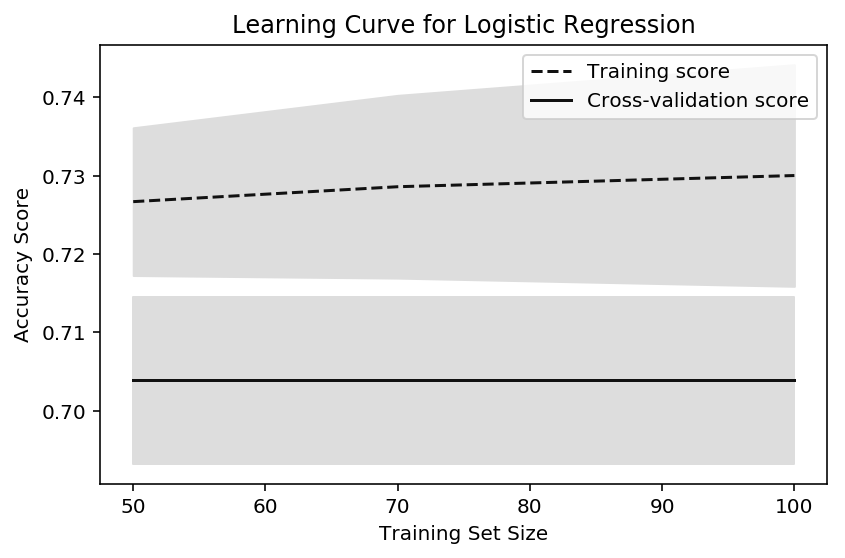

In [132]:
# TAKEN FROM SKLEARN
# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(lr, 
                                                        transformed_text, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=3,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=(50,70,100))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve for Logistic Regression")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()


#### Experiment 1 : Best model for SVM with TFIDF
- Text to Features: TFIDF using the article content
- Classification Model: SVM 

- Precision talks about how precise/accurate your model is out of those predicted positive, how many of them are actual positive. Should be the metric when there os a high cost associated with False Positive.
- Recall actually calculates how many of the Actual Positives our model capture through labeling it as Positive (True Positive). Recall shall be the model metric we use to select our best model when there is a high cost associated with False Negative.
- For our model both of them are equally important.
- F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. F1 is more useful than accuracy especially if you have an uneven class distribution. Accuracy works best if false positives and false negatives have similar cost. If the cost of false positives and false negatives are very different, it’s better to look at both Precision and Recall. 
- F1 Score = 2*(Recall * Precision) / (Recall + Precision)

In [26]:
X = data.tokenized_Content
y = data['Label']

In [27]:
tdf = TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS,ngram_range=(1,1),max_df =0.85,min_df=0.001)
vectorizer = tdf.fit(X)
transformed_text = vectorizer.transform(X)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(transformed_text,y, test_size = 0.2, random_state=1234)
print('X_train',X_train.shape)
print('X_test',X_test.shape)
print('y_train',y_train.shape)
print('y_test',y_test.shape)

X_train (129, 9159)
X_test (33, 9159)
y_train (129,)
y_test (33,)


In [29]:
svm = SGDClassifier(alpha= 0.001,loss ='hinge',penalty='l2')

In [30]:
svm.fit(X_train, y_train)
prediction = svm.predict(X_test)

C:\Users\tooba\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning:

max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.



In [31]:
# 3 cross validation scores
print(cross_val_score(svm, transformed_text, y, cv=3)) 

C:\Users\tooba\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning:

max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.



[0.65454545 0.7037037  0.71698113]


In [32]:
# print metrics
print ("SVM F1 and Accuracy Scores : \n")
print ( "F1 score {:.4}%".format( f1_score(y_test, prediction , average='macro')*100 ) )
print ( "Accuracy score {:.4}%".format(accuracy_score(y_test, prediction)*100) )
error = mean_squared_error(y_test, predicted)
print('MSE',error)

SVM F1 and Accuracy Scores : 



C:\Users\tooba\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



F1 score 31.97%
Accuracy score 66.67%
MSE 0.36363636363636365


- The value of the accuracy score and F1 score fluctuates alot for this even after Gridsearch. The maximum observed accuracy for the test data is around 72% and F1 score is around 31.97%. The best idea would be to go with the cross validated scores.

In [33]:
print(metrics.classification_report(y_test, prediction,target_names=['Fake','Unverified','Real']))

C:\Users\tooba\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

C:\Users\tooba\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

C:\Users\tooba\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



              precision    recall  f1-score   support

        Fake       0.00      0.00      0.00         1
  Unverified       0.20      0.14      0.17         7
        Real       0.75      0.84      0.79        25

   micro avg       0.67      0.67      0.67        33
   macro avg       0.32      0.33      0.32        33
weighted avg       0.61      0.67      0.64        33



In [34]:
X = data.tokenized_Content
y = data['Label']
tdf = TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS,ngram_range=(1,1),max_df =0.85,min_df=0.001)
vectorizer = tdf.fit(X)
transformed_text = vectorizer.transform(X)

 - We plot a learning curve to show the relationship of the training score vs the cross validated test score for an estimator with a varying number of training samples.

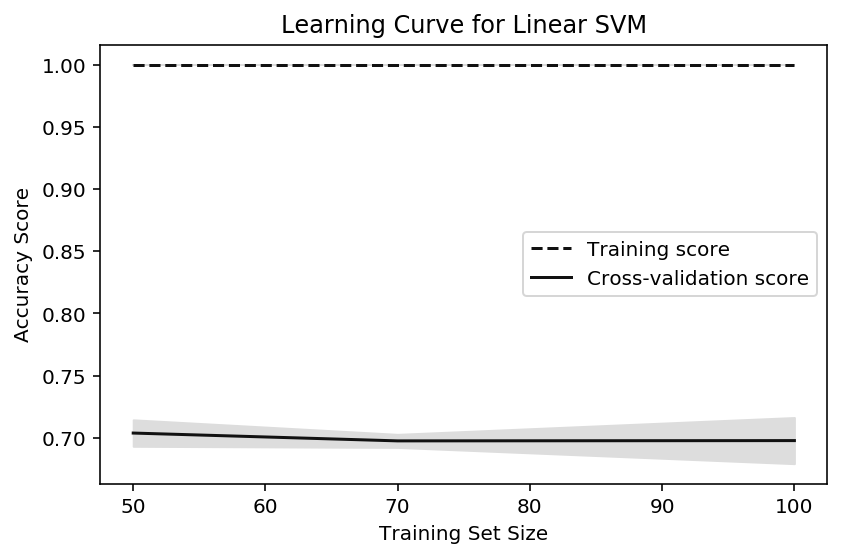

In [35]:
# TAKEN FROM SKLEARN
# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(svm, 
                                                        transformed_text, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=3,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=(50,70,100))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve for Linear SVM")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()


#### Comparison between final LR and Linear SVM model
- The range for the best accuracy score for both the models on the cross validation data-sets is as following:
SVM (63-73%) LR(69-71%). The range for LR is very narrow as compared to SVM.
- The accuracy score on the test data set(20% data) is 75.76% for LR while it is 72.73% for SVM 
- The f1 score for SVM(34.5) is much better than LR(28.7). However, since both false positives and false negatives have the same cost for our problem so we are looking only at the improvement of the accuracy score.
- Comparing thr scores for thr cross validation and LR, LR performs much better for our dataset.

#### Observations

- The training score is much greater than the validation score which means that the model probably requires more training examples in order to generalize more effectively.
- The curves are plotted with the mean scores, however variability during cross-validation is shown with the shaded areas that represent a standard deviation above and below the mean for all cross-validations. If the model suffers from error due to bias, then there will likely be more variability around the training score curve. If the model suffers from error due to variance, then there will be more variability around the cross validated score which is the case with our data (Not sure)

In [87]:
unverified = len(data[data['Label']==0])
real = len(data[data['Label']==1])
fake = len(data[data['Label']==-1])
pct_of_unverified = unverified /(unverified+real+fake)
print("percentage of unverified", pct_of_unverified*100)
pct_of_real = real /(unverified+real+fake)
print("percentage of real", pct_of_real*100)
pct_of_fake = fake /(unverified+real+fake)
print("percentage of fake", pct_of_fake*100)

percentage of unverified 27.160493827160494
percentage of real 70.37037037037037
percentage of fake 2.4691358024691357


- (Observation from learning curve when CV=10. Now we reduced it to CV =3)As we increase the value of cv while performing gridsearch with our models and features, the accuracy score across the hold out dataset decreases. The possible reason for this could be the class imbalance. From the above calculation we can see that the amout of data with fake news is extremely small so it is possible that these examples doesn't come in the training set during cv and the model sees this unexpected class in the test set resulting in a false positive.
- The best results for our data comes with CV = 3 